# Mushroom Classification

Hi! Thanks for checking this notebook. 

Aside from applying some ML techniques to classify if a mushroom is edible or poisonous, we'll try to determine the most important features for this decision. 

Finally, the interpretation of the most relevant features is briefly explained using the odds ratio computed from the logistic regression algorithm.

In [1]:
import dython.nominal as dm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('seaborn')
pd.set_option("display.max_rows", 100)

In [2]:
data = pd.read_csv("../input/mushrooms.csv")

Let's explore the data

In [3]:
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
data.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


With this initial overview of the data its possible to conclude that:

1. All variables are categorical
2. The response variable "class" presents only two categories (edible and poisonous) making this a binary classification problem
3. The  data seems to be evenly balanced between the two categories we are trying to predict
4. "veil-type" only has one category so it does not provide any useful information for the classification procedure


In [ ]:
data = data.drop(['veil-type'], axis=1)

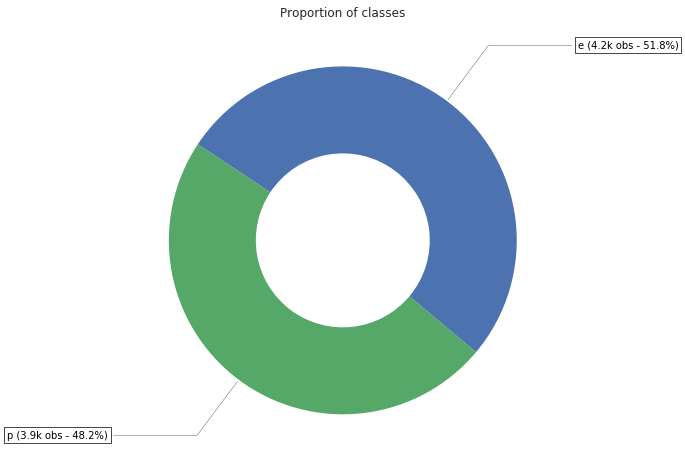

In [31]:
def donut_chart(data):
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(aspect="equal"))

    recipe = list(data.value_counts().index)

    info = data.value_counts()

    def pcts(val_list):
        pct = []
        for val in val_list:
            pct.append(" ({:.1f}k obs - {:.1f}%)".format(val/1000, 100*val/np.sum(val_list)))
        return pct

    recipe2 = pcts(info)

    wedges, texts = ax.pie(info, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        kw["color"] = 'k'
        ax.annotate(recipe[i]+recipe2[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)

    ax.set_title("Proportion of classes")

    plt.show()
    
donut_chart(data['class'])

In [32]:
data.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

The two classes are indeed evenly distributed across the dataset.

The data doesn't exhibit missing values and since all the variables are categorical there is no need to take outliers into consideration. Really easy dataset to work with, cheers to the people involved in its creation!

We desire to see what are the most important features for the classification problem at hand and to visually explore the data. However, correlation is of no use in this scenario and there is no numerical info to plot. 

With this in mind, the following plots are constructed for each feature: 

1. The crosstab count between the feature and the class (upper center)
    1.1 The value of Cramer's V for the feature and the class
2. The proportion of features across classes (lower left)
    2.1 The value of Theils' U for the feature given the class
3. The proportion of classes across features (lower right)
    3.1 The value of Theils' U for the class given the feature

**A couple of notes:
- Cramer's V is symmetrical
- Theils' U is not symmetrical
- The proportion of features across classes is an estimate of the conditional probability of having a feature given a class P(feature|class)
- The latter is also true for the other way around
**

In [18]:
def generate_freq_heatmaps(feature):
    wild_ct = pd.crosstab(data[feature], 
                          data['class'])

    wild_ct_pct = wild_ct.apply(lambda r: r/r.sum(), axis=0)
    wild_ct_pct2 = wild_ct.apply(lambda r: r/r.sum(), axis=1)
    #wild_ct_pct3 = pd.DataFrame(wild_ct_pct.values*wild_ct_pct2.values, columns=wild_ct_pct.columns, index=wild_ct_pct.index)
    
    cram_v = dm.cramers_v(data[feature], data['class'])
    t_u_given_class = dm.theils_u(data[feature], data['class'])
    t_u_given_feature = dm.theils_u(data['class'], data[feature])
    
    plt.figure(figsize=(15,12))
    #plt.figure(figsize=(8,6))

    ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, 
                           title=f"Overall Count of {feature} \n Cramer's V: {cram_v:.3f}")
    ax2 = plt.subplot2grid((3,2), (1, 0), 
                           title=f"P({feature}|class) \n Theil's U: {t_u_given_class:.3f}")
    ax3 = plt.subplot2grid((3,2), (1, 1), 
                           title=f"P(class|{feature}) \n Theil's U: {t_u_given_feature:.3f}")
    #ax4 = plt.subplot2grid((3,2), (2, 0), colspan=2, title=f'P({feature}|Class)*P(Class|{feature})')

    sns.heatmap(wild_ct, cmap=sns.color_palette("BuGn"), annot=True, fmt='g', ax=ax1)
    sns.heatmap(wild_ct_pct, cmap=sns.color_palette("GnBu"), annot=True, fmt='.0%', ax=ax2)
    sns.heatmap(wild_ct_pct2, cmap=sns.color_palette("GnBu"), annot=True, fmt='.0%', ax=ax3)
    #sns.heatmap(wild_ct_pct3, cmap=sns.color_palette("GnBu"), annot=True, fmt='.1%', ax=ax4)

    plt.tight_layout()
    plt.show()

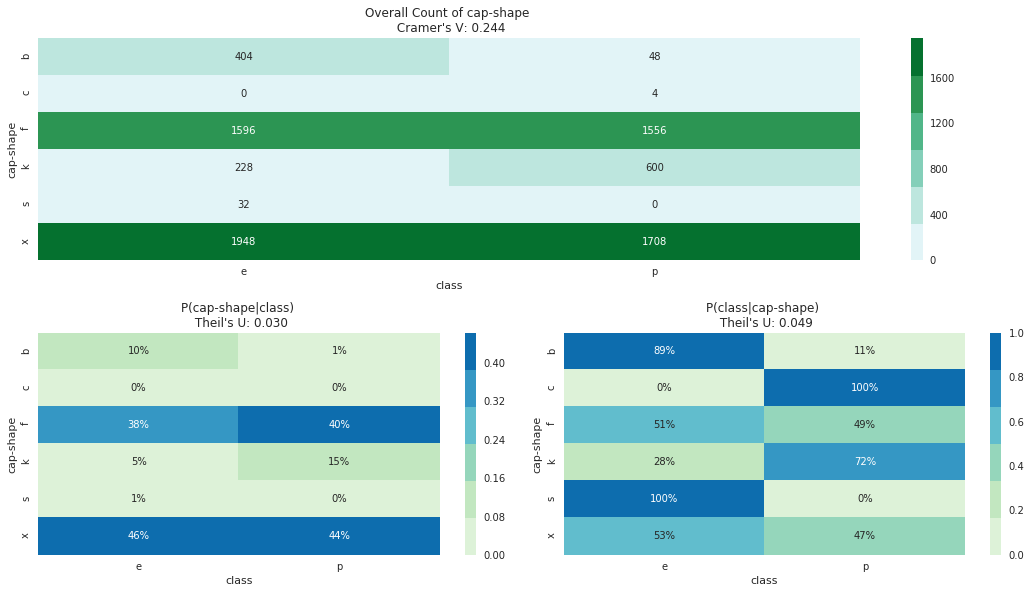

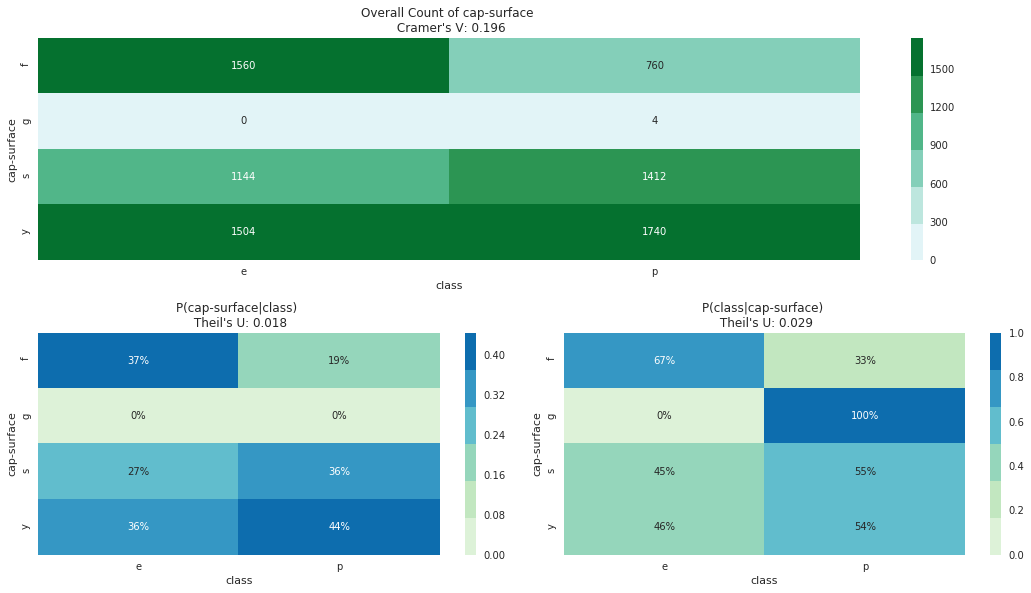

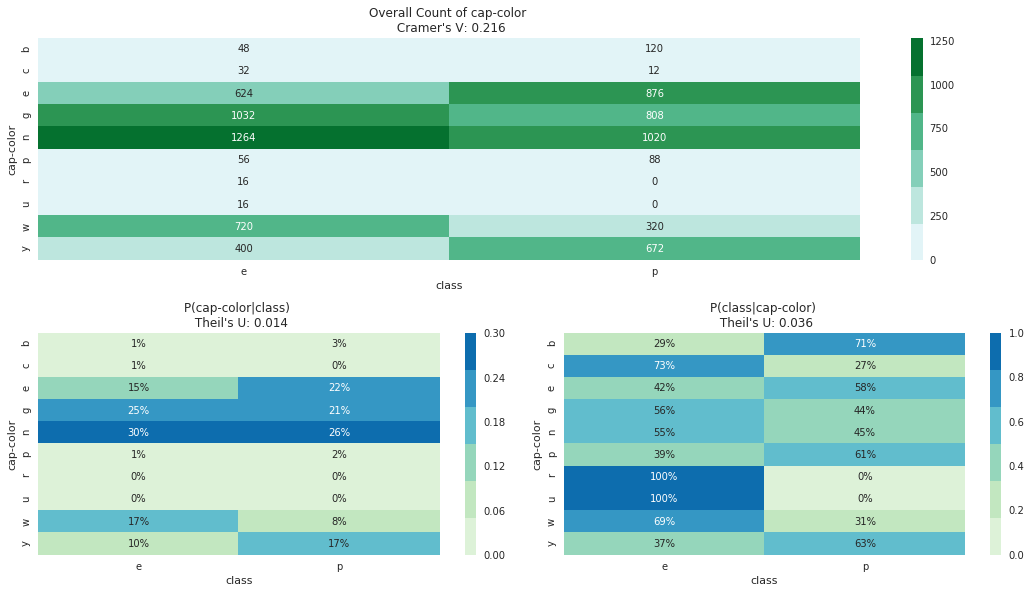

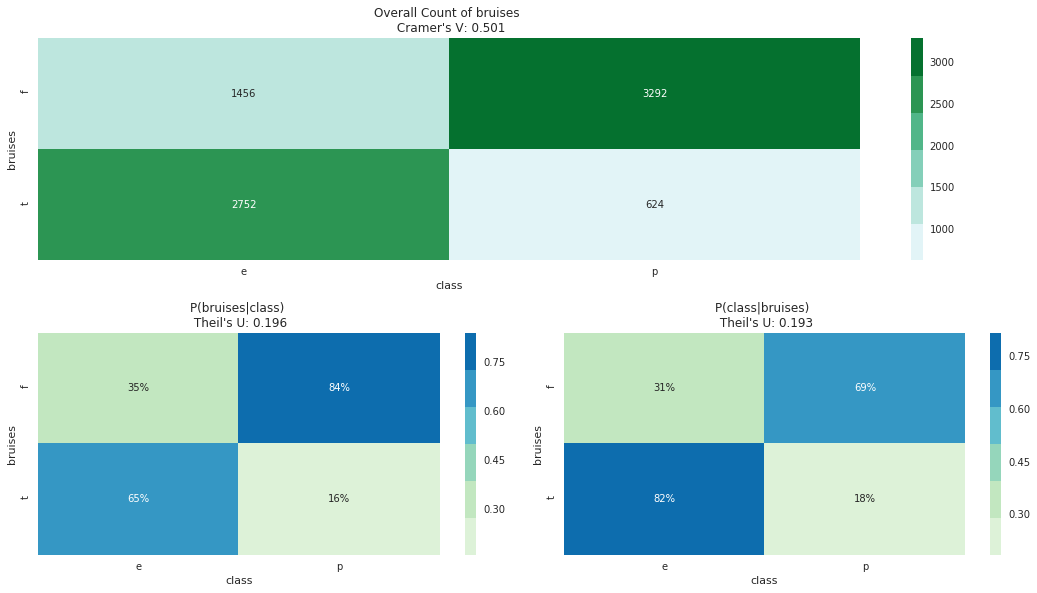

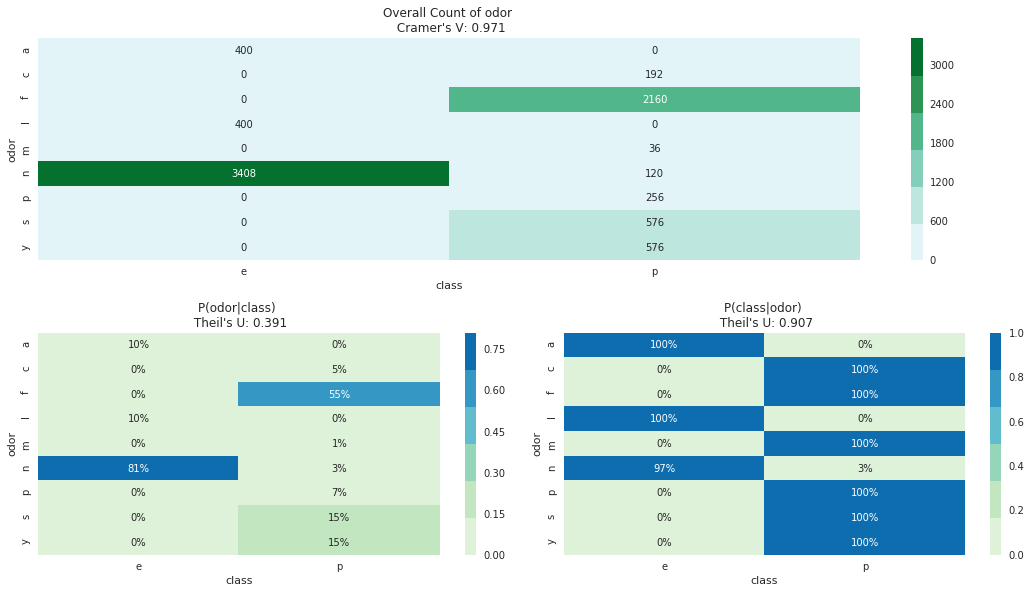

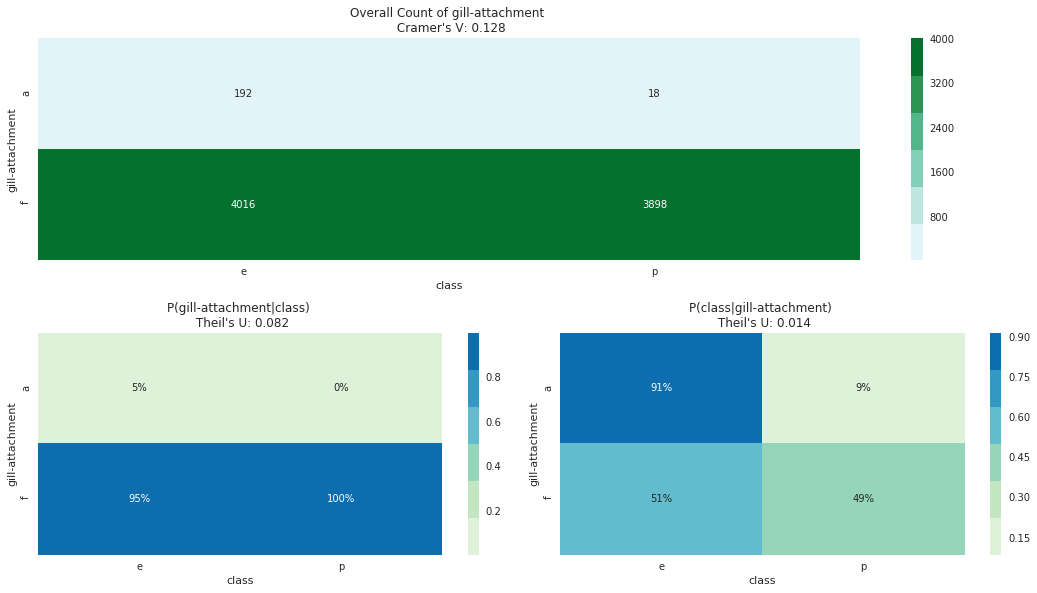

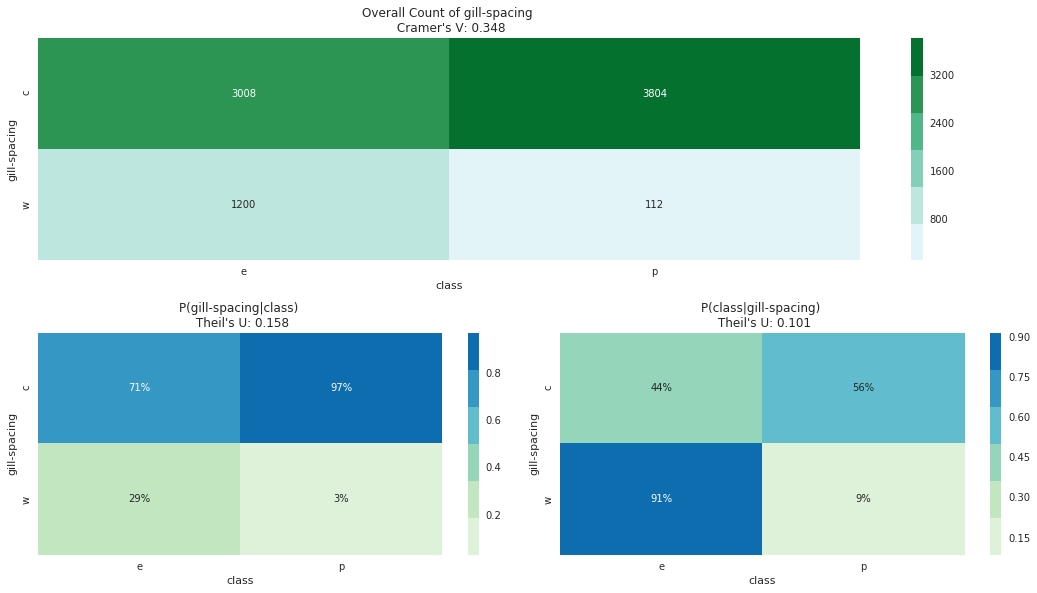

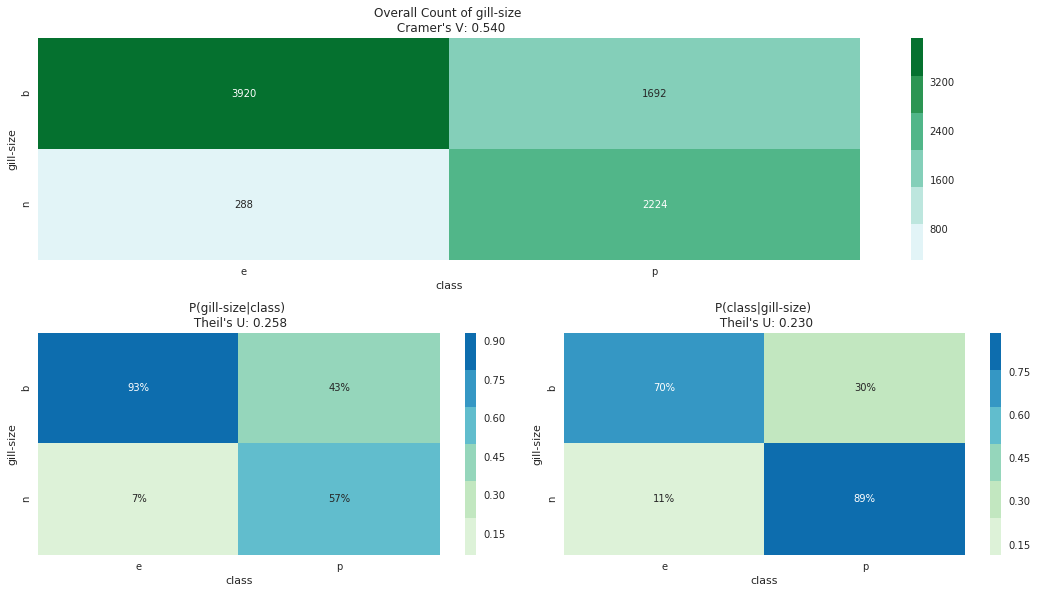

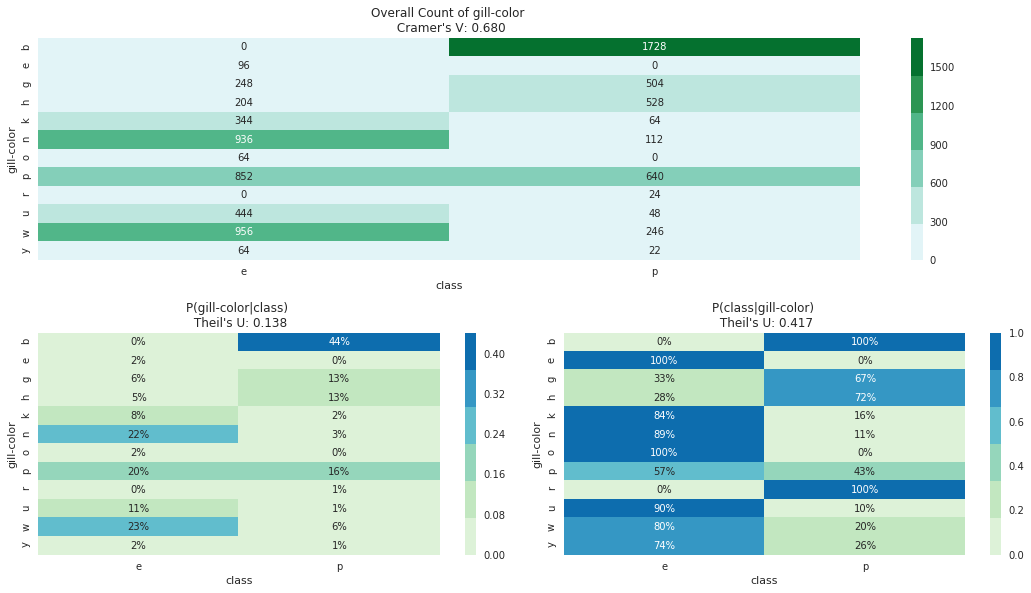

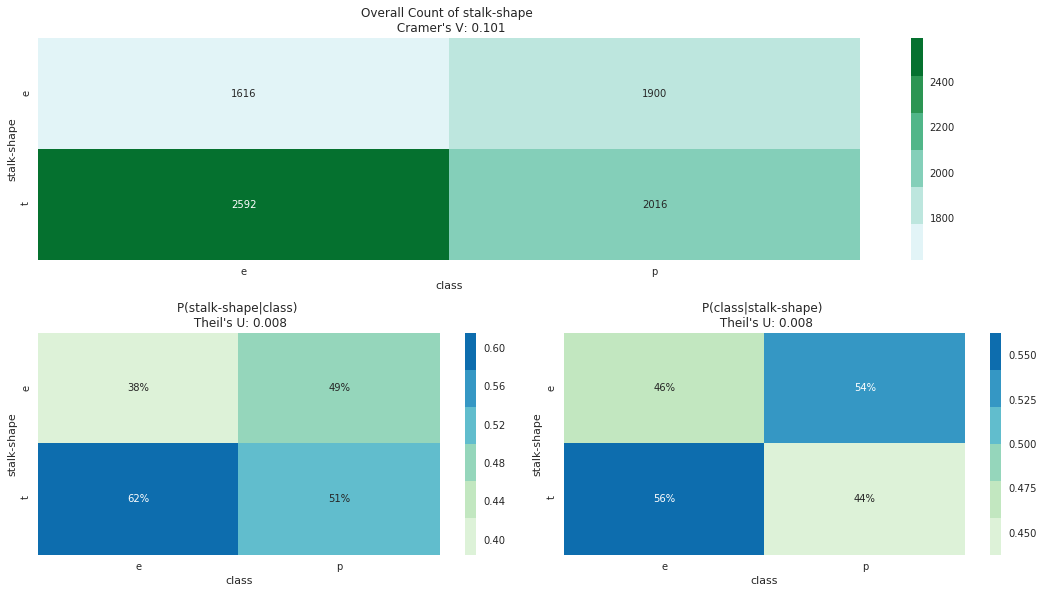

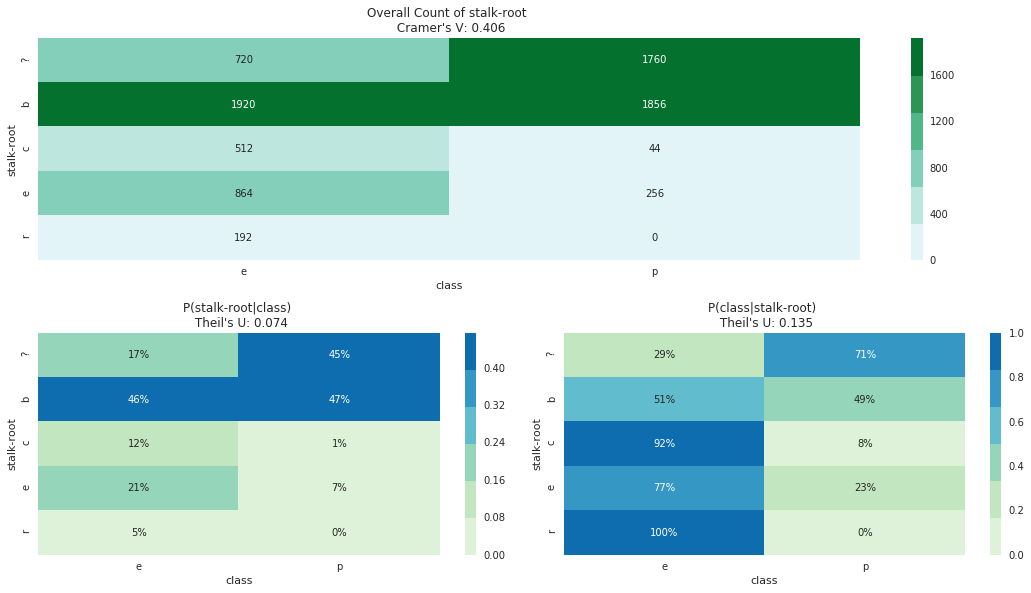

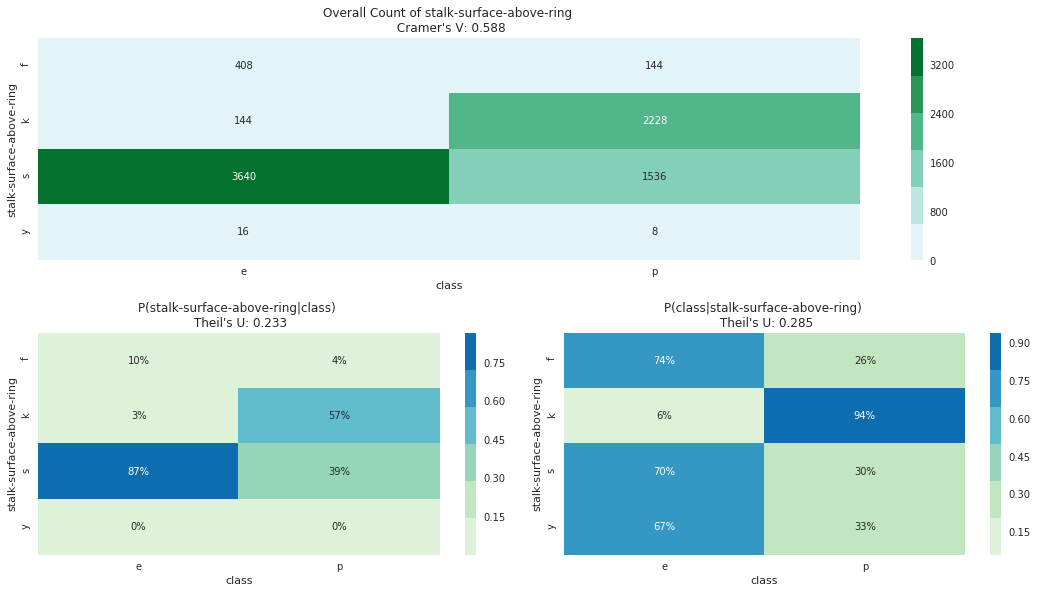

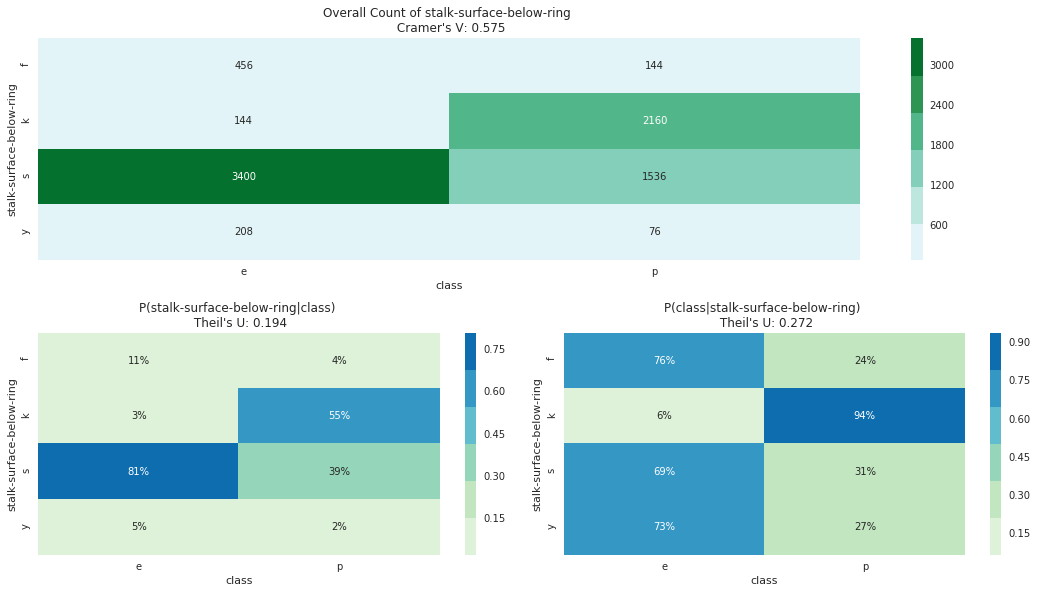

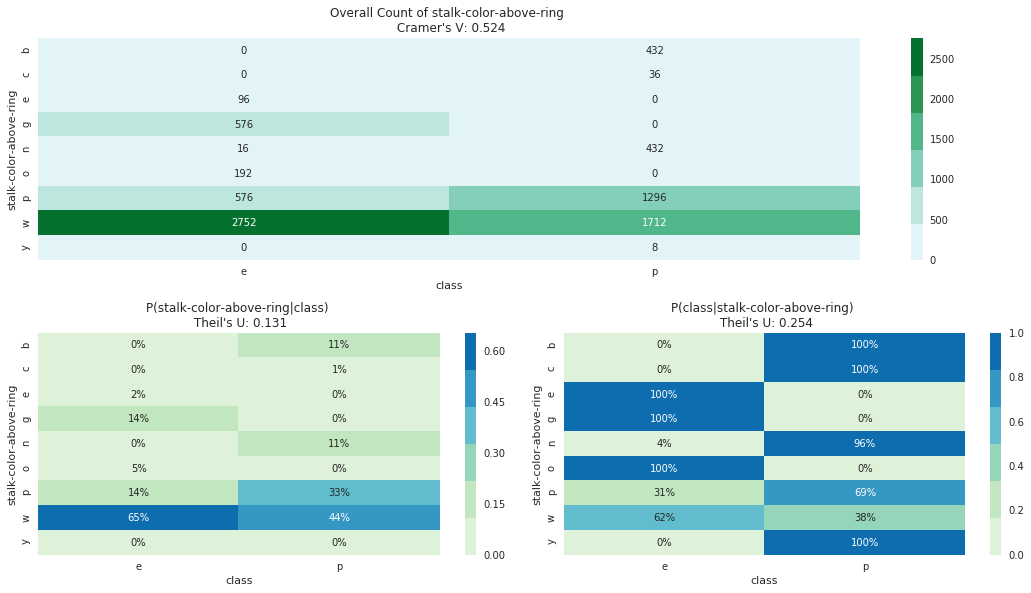

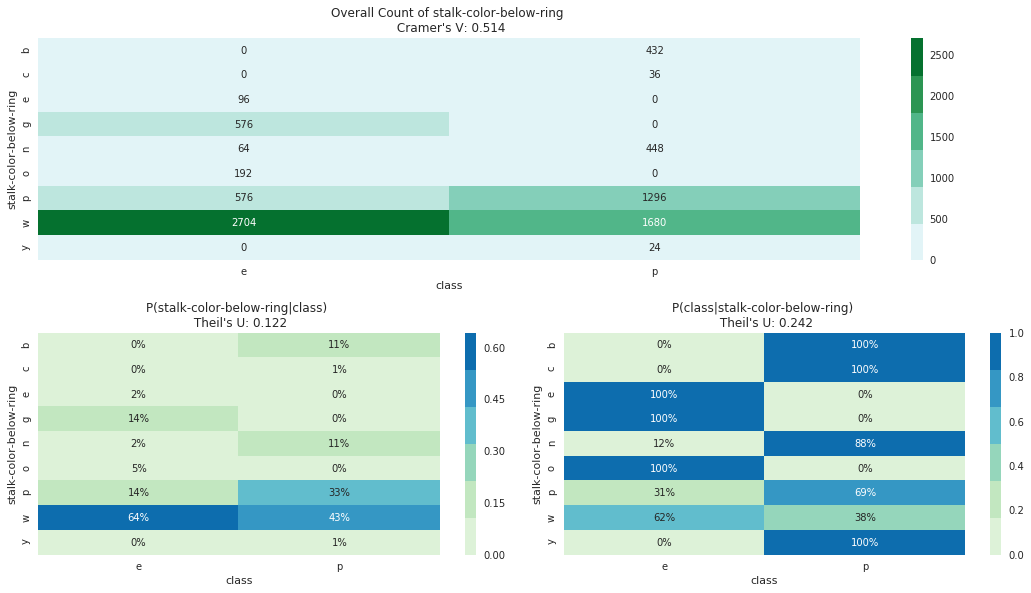

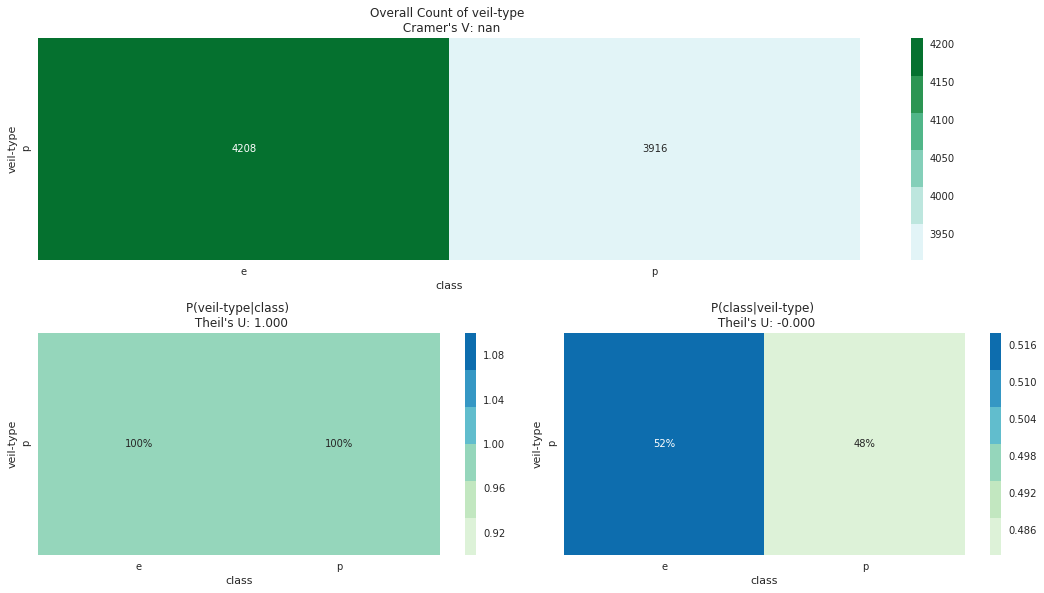

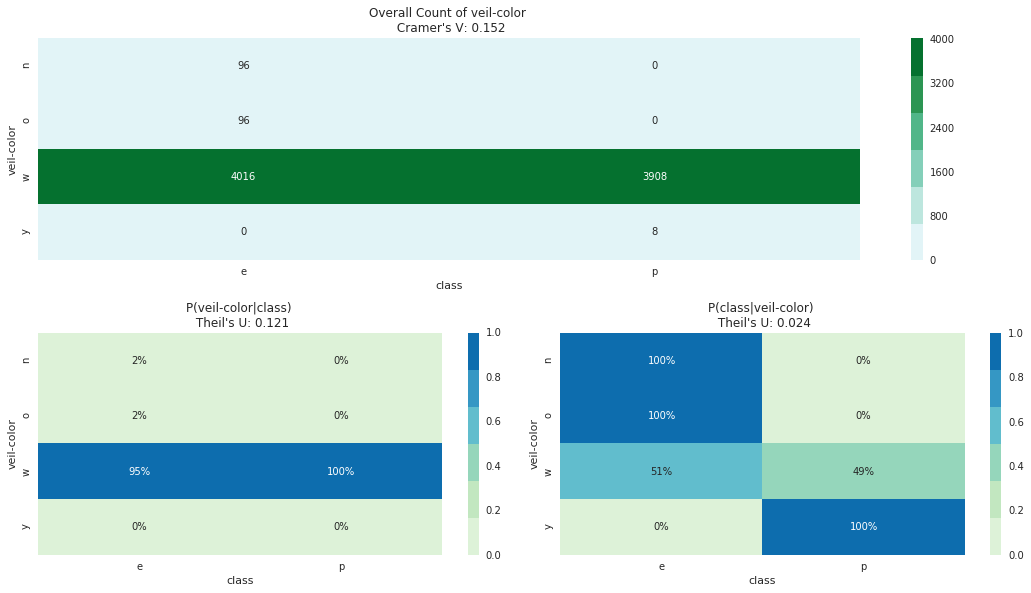

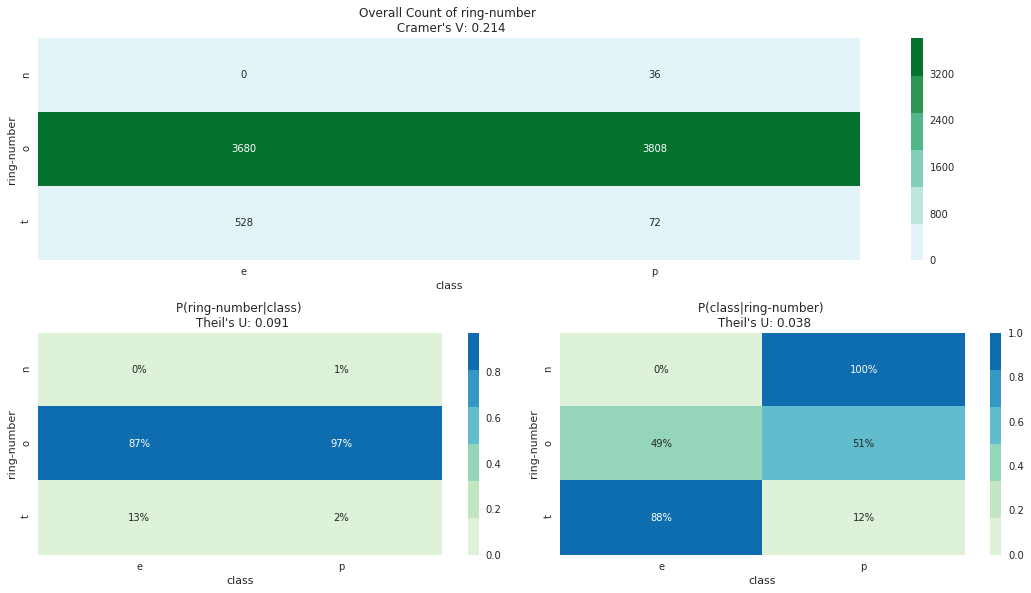

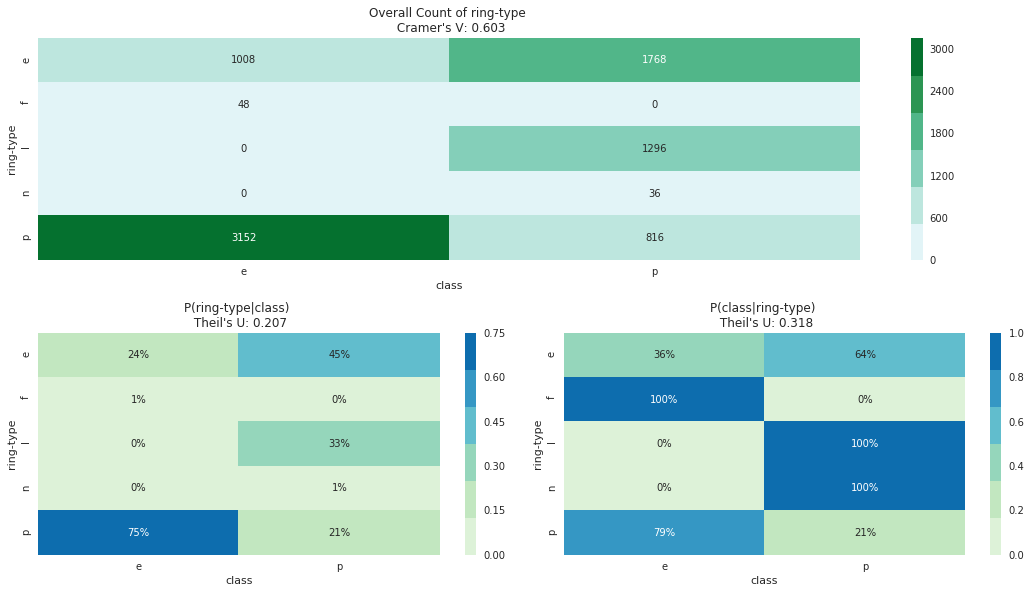

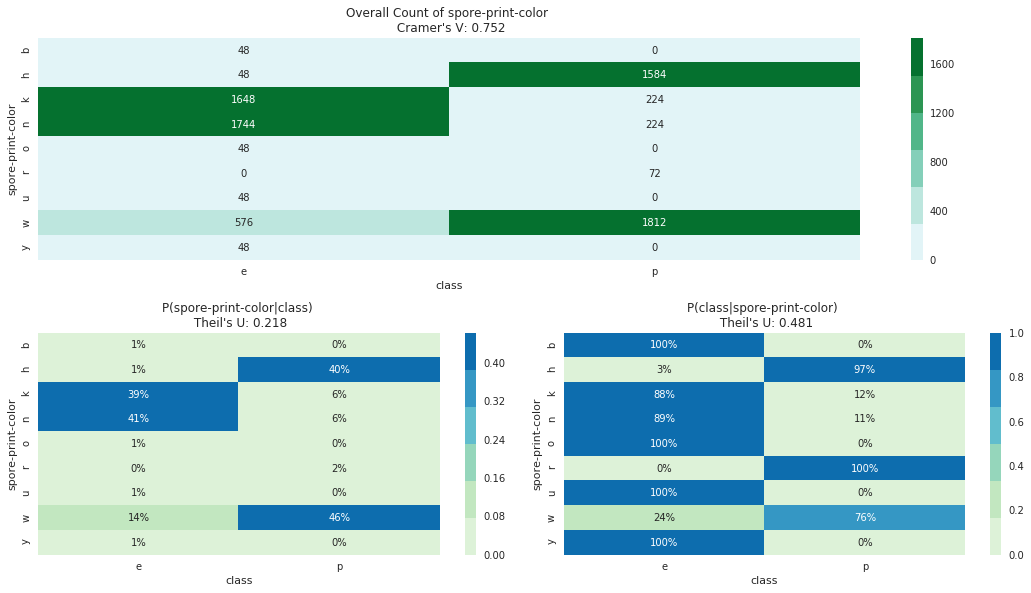

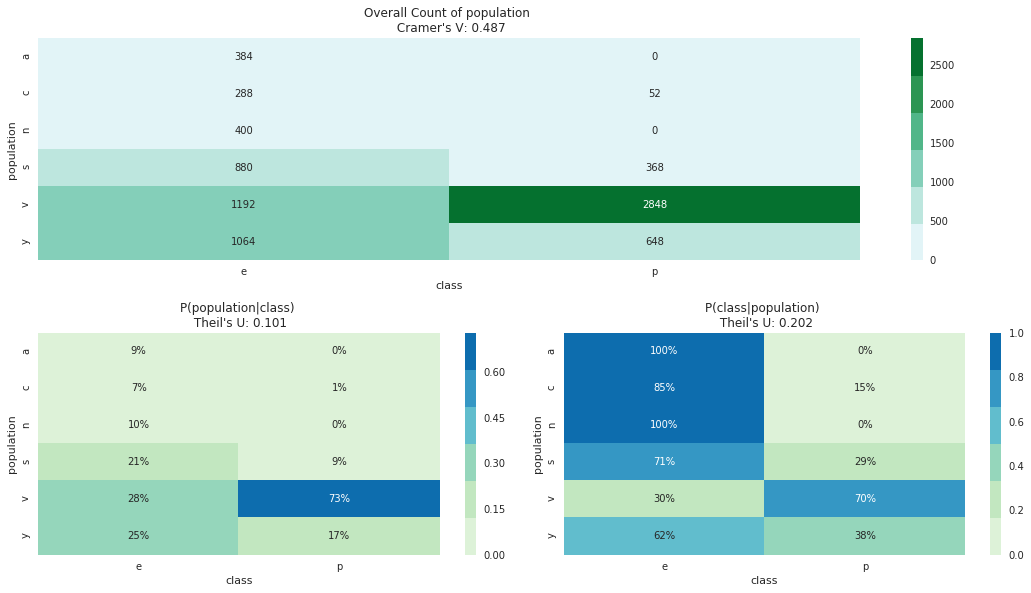

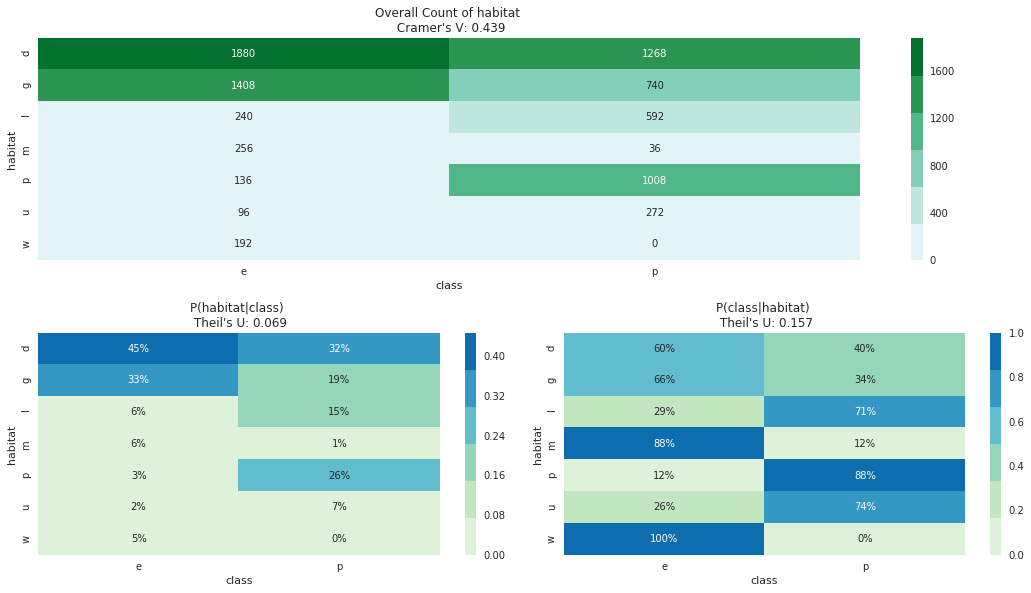

In [19]:
features = [col for col in data.columns if col != 'class']

for feature in features:
    generate_freq_heatmaps(feature)

That was a lot of data to visualize.

Let's compact the results to determine the most relevant features.

Ordered plots for Cramer's V and Theil's U (for the class given the feature) are present below:

**
Note: only one value for Theil's U is considered, concretely the one that takes into account the class given the feature because that is the way our model will work, a prediction of a class given a feature.
**

In [43]:
def get_nominal_scores(func):
    scores = pd.DataFrame(features, columns=['feature'])
    scores['score'] = scores['feature'].apply(lambda x: func(data['class'], data[x]))
    scores = scores.sort_values(by='score', ascending=False)
    return scores

In [44]:
cramers_vs = get_nominal_scores(dm.cramers_v)
theils_us = get_nominal_scores(dm.theils_u)

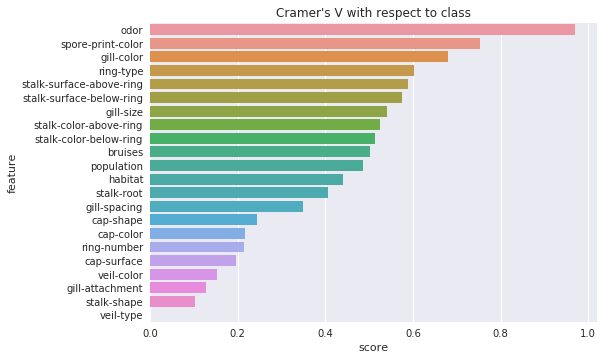

In [42]:
ax = sns.barplot(x="score", y="feature", data=cramers_vs)
ax.set_title("Cramer's V with respect to class")
plt.show()

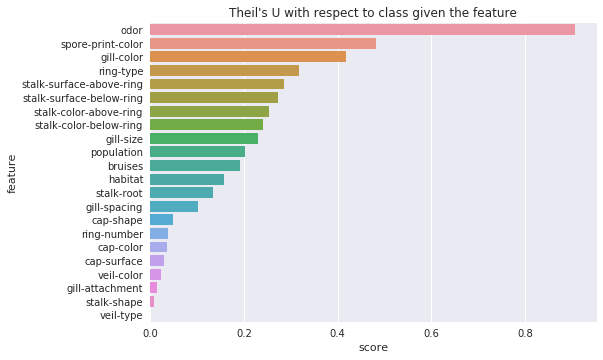

In [45]:
ax = sns.barplot(x="score", y="feature", data=theils_us)
ax.set_title("Theil's U with respect to class given the feature")
plt.show()

Both metrics agree on the 9 most important features (although in slighlty different order), which are:

- odor
- spore-print-color
- gill-color
- ring-type
- stalk-surface-above-ring
- stalk-surface-below-ring
- gill-size
- stalk-color-above-ring
- stalk-color-below-ring

In [ ]:
data = pd.get_dummies(data, drop_first=True)
data.head()

After converting all variables to dummies, the response variable is 1 if mushroom is poisonous and 0 if not. In this case it is considered a "success" if the mushroom is indeed poisonous.
Now let's separate the response variable from the predictors and create our train and test subsets:

In [ ]:
y = data.iloc[:,0:1]
X = data.iloc[:,1:]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

First we'll be using XGBoost to define a classification model and identify important features:

In [ ]:
import xgboost
from sklearn import metrics
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [ ]:
auc_roc_xgb = metrics.roc_auc_score(y_test,y_pred_xgb)
print("auc score = {}".format(auc_roc_xgb))
confusion_matrix_xgb = metrics.confusion_matrix(y_test,y_pred_xgb)
confusion_matrix_xgb

XGBoost model is able to perfectly classify is a mushroom is edible or not. Let's look at the most important features in this model:

In [ ]:
#Plot
xgboost.plot_importance(xgb)

In [ ]:
#List
df_xgb = pd.DataFrame({'x': np.array(X.columns), 'y':xgb.feature_importances_})
df_xgb.sort_values('y', ascending=False)

The most important features when classifying if a mushroom is edible or not are:
* spore-print-color
* odor
* bruises
* gill-size
* gill-spacing

**In order to get an interpretation out of these features let's fit a logistic regression to the data. This, because Logit is a linear model and its interpretation is easier:**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred_log = logit.predict(X_test)

In [ ]:
auc_roc_log =metrics.roc_auc_score(y_test,y_pred_log)
print("auc score = {}".format(auc_roc_log))
confusion_matrix_log = metrics.confusion_matrix(y_test,y_pred_log)
confusion_matrix_log

Logit performs almost as well as XGBoost and because of this we can safely interpret its results. 

**The coefficients of the logit regression can be used to calculate the Odds Ratio of each variable. In this case the Odds Ratio is calculated against the base (the dummy variable that was left out) and this happens to all features since they all are categorical.**

In [ ]:
df_log = pd.DataFrame({'x': np.array(X.columns), 'beta':logit.coef_[0]})
df_log['OR'] = np.exp(df_log['beta'])
df_log

**Let's check the OR (Odds Ratio) for the most important features found in the XGBoost model:

**It is important to notice that a bigger OR corresponds to a bigger magnitude of the odds of having a "success". In this case this represents the chances of the mushroom being poisonous. So a bigger OR is an indication of danger.****

In [ ]:
df_log[df_log['x'].str.contains("spore-print-color")]

***In this case the base corresponds to spore-print-color = buff. Given the OR's for the rest of colors we can conclude that the most dangerous colors for spore print are (in order of magnitude):***

* Green
* White
* Chocolate

In [ ]:
df_log[df_log['x'].str.contains("odor")]

***In this case the base corresponds to odor = almond. Given the OR's for the rest of odors we can conclude that the most dangerous odors are (in order of magnitude):***

* Creosote
* Pungent
* Foul
* Fishy
* Spicy
* Musty

In [ ]:
df_log[df_log['x'].str.contains("bruises")]

***In this case the base corresponds to bruises = False. Given the OR for having bruises it is safer if a mushroom presents bruises than if it doesn't***


In [ ]:
df_log[df_log['x'].str.contains("gill-size")]

***In this case the base corresponds to gill size = broad. Given the OR for gill size = narrow it is safer if a mushroom presents broad gill size than if it doesn't***

In [ ]:
df_log[df_log['x'].str.contains("gill-spacing")]

***In this case the base corresponds to gill spacing = close. Given the OR for gill spacing = crowded it is safer if a mushroom presents crowded gill spacing than if it doesn't***
